<h1> Some demonstrations of Fourier properties in image processing </h1>

This notebook will demonstrate concepts in image processing from a Fourier analysis perspective.

The notebook uses some functions from my `impro_utils.py` module.

It assumes the user has some knowledge of Fourier transforms.

The image used in this notebook is a .jpg file acquired from http://www.facweb.iitkgp.ac.in/~shamik/spring2008/sca/tutorials/download/pami.uwaterloo.ca/tizhoosh/images/test2.jpg.

In [2]:
# Import statements
import impro_utils as imp
import numpy as np
import matplotlib.pyplot as plt
import copy

plt.rcParams.update({'font.size': 40})

<h3> Reading in data </h3>

(256, 256)


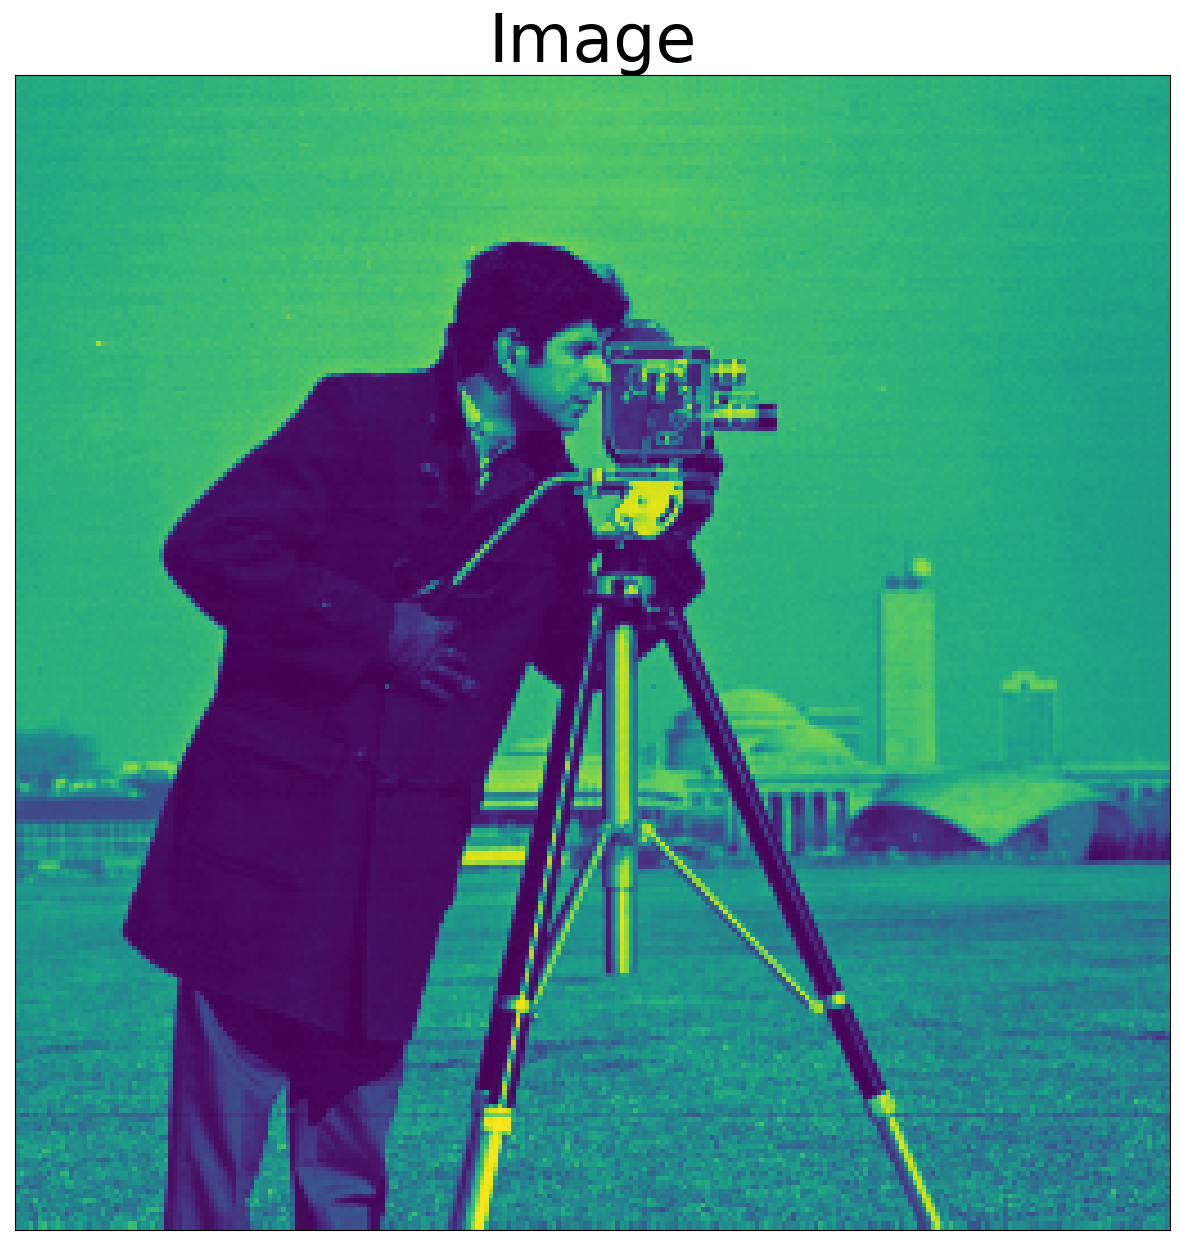

In [11]:
filename = 'images/test2.jpg'
image = imp.load_data(filename)
print(np.shape(image))
fig = plt.figure(figsize=(20,15))
imp.plot_img(image, "Image")

<h3> K-space </h3>

K-space is another name for the Fourier domain, or the domain of frequencies. Spatial frequencies are represented on a 2D grid, where each point is the sum over the image for each respective frequency. The k-space centre is the highest point. The k-space data $S(k)$ is obtained via Fourier Transform of the image $S(x)$.

Continuous (1D):
$$ S(k) = \int_{-\infty}^{\infty}S(x)e^{-2\pi ikx}dx $$

Discrete (2D):
$$ S_{kj}=\sum\limits^{M-1}_{m=0}\sum\limits^{N-1}_{n=0} S_{mn} e^{-2\pi ikm} e^{-2\pi ijn} $$

To retrieve the image $S(x)$, an Inverse Fourier Transform (IFT) is used:


Continuous (1D):
$$ S(x) = \int_{-\infty}^{\infty}S(k)e^{2\pi ikx}dk $$

Discrete (2D):
$$ S_{mn}=\sum\limits^{K-1}_{k=0}\sum\limits^{J-1}_{j=0} S_{kj} e^{2\pi ikm} e^{2\pi ijn} $$

Missing or corrupted k-space data can cause image artifacts. Some examples are shown below.

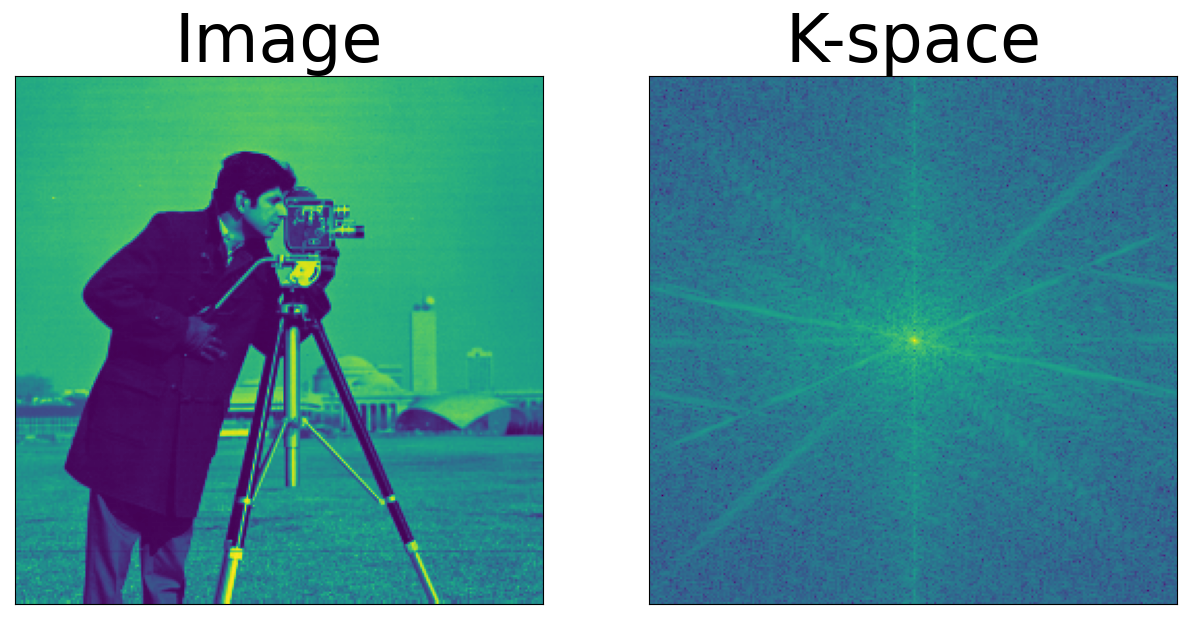

In [4]:
kspace = imp.fft2d(image)

fig = plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
imp.plot_img(image, "Image")
plt.subplot(1,2,2)
imp.plot_img(abs(np.log(kspace+1)), "K-space")

<h3> Real, Imaginary and Phase </h3>

K-space (and all complex data) are composed of real and imaginary numbers of the form $c = a + ib$ where $i = \sqrt{-1}$

Complex numbers can be represented on a 2D plane, like a vector, where the length of the vector is the magnitude of the complex number (L2-norm) and the angle the vector makes with the real axis is its phase, $\phi = \tan^{-1}\left(\frac{Im(c)}{Re(c)}\right)$.

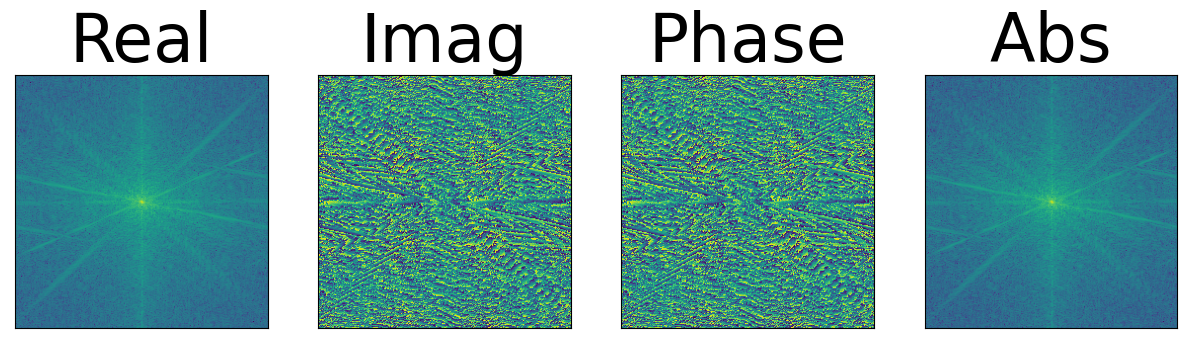

In [5]:
fig = plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
imp.plot_img(np.real(np.log(kspace)+1), "Real")

plt.subplot(1,4,2)
imp.plot_img(np.imag(np.log(kspace)+1), "Imag")

plt.subplot(1,4,3)
imp.plot_img(np.angle(kspace), "Phase")

plt.subplot(1,4,4)
imp.plot_img(np.abs(np.log(kspace)+1), "Abs")

The phase of the k-space data is just as important, if not more, than its magnitude. Shown below is the image with the phase set to a constant value.

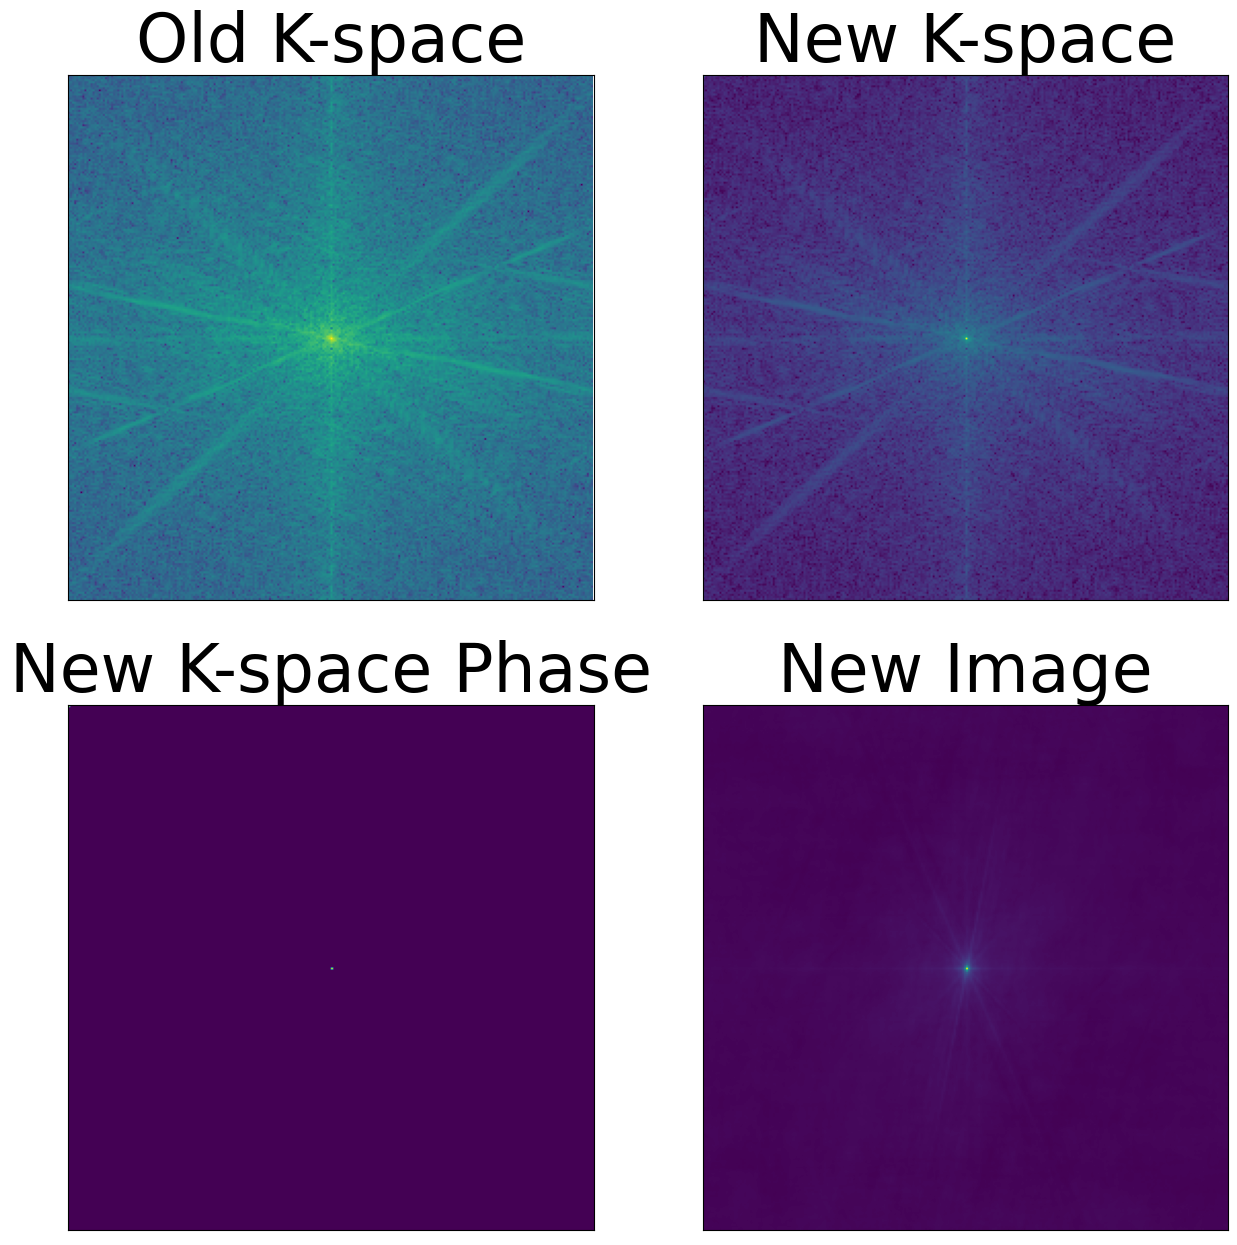

In [8]:
new_kspace_phase = np.angle(kspace)/(np.angle(kspace)+1e-5) # Small value added to avoid divide by zero error

new_kspace = abs(kspace)*np.exp(-2*np.pi*new_kspace_phase)

fig = plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
imp.plot_img(np.abs(np.log(kspace)+1), "Old K-space")

plt.subplot(2,2,2)
imp.plot_img(np.abs(np.log(new_kspace)+1), "New K-space")

plt.subplot(2,2,3)
imp.plot_img(np.angle(new_kspace_phase), "New K-space Phase")

plt.subplot(2,2,4)
imp.plot_img(np.abs(imp.ifft2d(new_kspace)), "New Image")

<h3> Crude high pass and low pass filters </h3>

If the k-space centre is missing or altered, it is equivalent to an image undergoing a high pass filter (edge enhancement).

If the edges of k-space are missing or altered, it is equivalent to an image undergoing a low pass filter (blurring).

The ringing on the image features in the low-pass filter is due to the Gibbs phenomenon. Sharp truncation in the Fourier domain is equivalent to a product of a box function across k-space. When k-space is Fourier transformed back to image space, this box becomes a sinc function and is convolved with the underlying image per the convolution theorem. This produces the "ringing" or "rippling" effect.

For an easier (and better) way to blur or enhance edges on an image, see `example.ipynb`

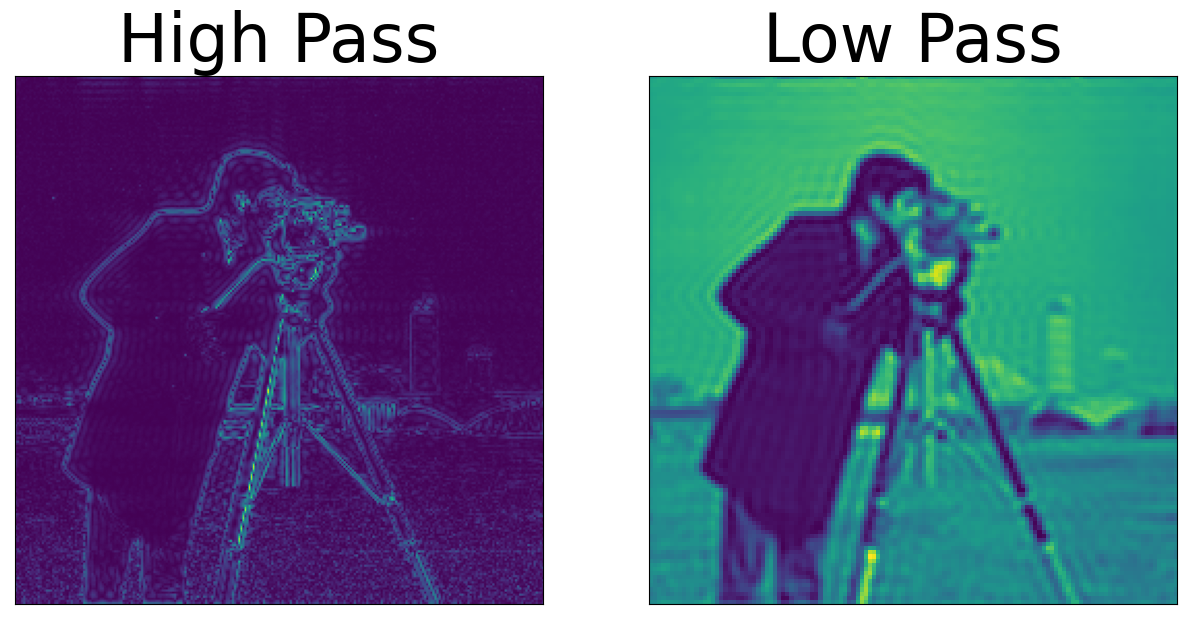

In [7]:
high_pass_kspace = kspace.copy()

high_pass_kspace[128-32:128+32, 128-32:128+32] = 0
high_pass_image = imp.ifft2d(high_pass_kspace)

low_pass_kspace = imp.zero_padder(kspace[128-32:128+32, 128-32:128+32],[128,128])
low_pass_image = imp.ifft2d(low_pass_kspace)

fig = plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
imp.plot_img(abs(high_pass_image), "High Pass")

plt.subplot(1,2,2)
imp.plot_img(abs(low_pass_image), "Low Pass")

<h3> Aliasing </h3>

If k-space data is undersampled, the image may fold back onto itself. This effect is known as "aliasing", and can occur in all spatial directions individually or simultaneously.

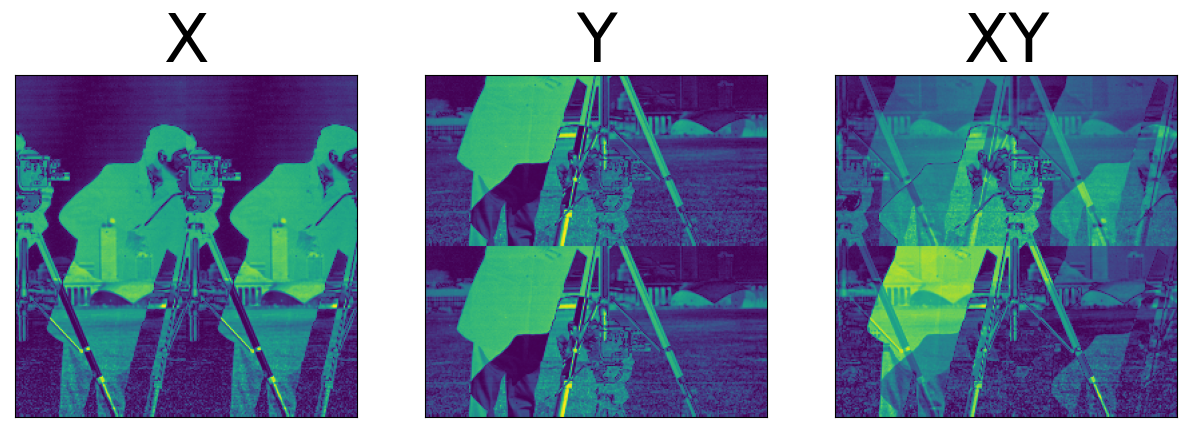

In [8]:
kspace_x = kspace.copy()
kspace_y = kspace.copy()
kspace_xy = kspace.copy()

kspace_x[:, ::2] = 0
kspace_y[::2, :] = 0
kspace_xy[::2, ::2] = 0

image_x = imp.ifft2d(kspace_x)
image_y = imp.ifft2d(kspace_y)
image_xy = imp.ifft2d(kspace_xy)

fig = plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
imp.plot_img(np.abs(image_x), "X")

plt.subplot(1,3,2)
imp.plot_img(np.abs(image_y), "Y")

plt.subplot(1,3,3)
imp.plot_img(np.abs(image_xy), "XY")

<h3> DC Offset and Sinusoidal Artifacts </h3>

Data corruption can sometimes manifest as a spike in the k-space data. When this happens, the underlying image is affected drastically depending on which point in k-space is affected.

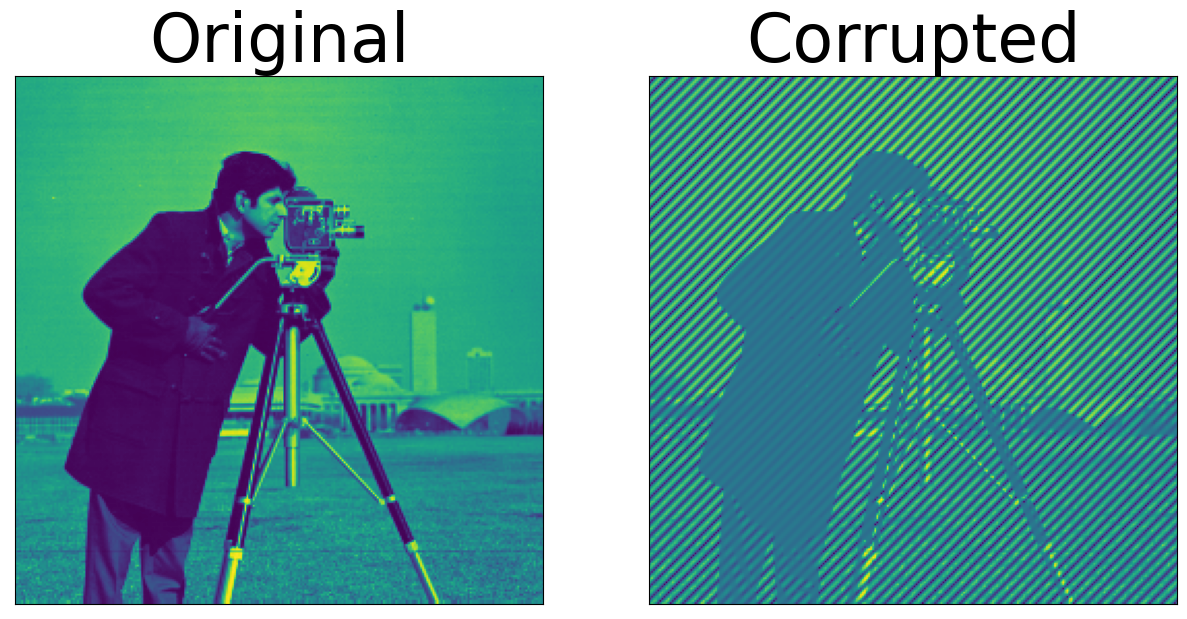

In [42]:
kspace_spike = kspace.copy()

kspace_spike[170, 170] = 1e7
image_spike = imp.ifft2d(kspace_spike)

fig = plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
imp.plot_img(np.abs(image), "Original")

plt.subplot(1,2,2)
imp.plot_img(np.abs(image_spike), "Corrupted")